In [698]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [699]:
# Numerical Dataset
df = pd.read_csv('../datasets/filtered_numerical_dataset.csv')
df.head()

,Overall Qual,Gr Liv Area,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Year Built,Year Remod/Add,Full Bath,Garage Yr Blt,Mas Vnr Area,TotRms AbvGrd,Id,SalePrice
0,6,1479,475.0,2.0,725.0,725,1976,2005,2,1976.0,289.0,6,109,130500
1,7,2122,559.0,2.0,913.0,913,1996,1997,2,1997.0,132.0,8,544,220000
2,5,1057,246.0,1.0,1057.0,1057,1953,2007,1,1953.0,0.0,5,153,109000
3,5,1444,400.0,2.0,384.0,744,2006,2007,2,2007.0,0.0,7,318,174000
4,6,1445,484.0,2.0,676.0,831,1900,1993,2,1957.0,0.0,6,255,138500


In [700]:
top_corr = df.corr().abs().drop(['Id','SalePrice'])[['SalePrice']].sort_values('SalePrice', ascending=False)
top_corr

,SalePrice
Overall Qual,0.799020
Gr Liv Area,0.698018
Garage Area,0.648760
Garage Cars,0.646917
Total Bsmt SF,0.629323
1st Flr SF,0.620635
Year Built,0.571326
Garage Yr Blt,0.555339
Year Remod/Add,0.549489
Full Bath,0.539027


In [701]:
# Start with one
features = ['Overall Qual']

#### Begin: Utilizing methods described in regularization lecture

In [702]:
X = df[features] # Using raw top correlated variables for features to keep poly transform manageable
y = df['SalePrice'].map(np.log)

In [703]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2027 entries, 0 to 2026
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Overall Qual  2027 non-null   int64
dtypes: int64(1)
memory usage: 16.0 KB


In [704]:
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y, random_state=42)

In [705]:
X_train.head()

,Overall Qual
381,7
567,6
425,2
1901,8
1823,6


In [706]:
lr = LinearRegression()
lr.fit(X_train, y_train_log)

LinearRegression()

In [707]:
lr.score(X_train, y_train_log), lr.score(X_test, y_test_log)

(0.6645745044201679, 0.7065003229509021)

In [708]:
cross_val_score(lr, X_train, y_train_log).mean()

0.6640022471402658

The variability appears to be low, but the bias is a bit high

In [709]:
pred_log = lr.predict(X_test)
pred = pd.Series(pred_log).map(np.exp).values

In [710]:
y_test_log.head()

1284    12.256766
982     12.182804
1543    12.793859
593     11.964001
1292    11.580584
Name: SalePrice, dtype: float64

In [711]:
y_test = pd.Series(y_test_log).map(np.exp)
y_test.head()

1284    210400.0
982     195400.0
1543    360000.0
593     157000.0
1292    107000.0
Name: SalePrice, dtype: float64

In [712]:
resid_log = y_test_log - pred_log
resid = y_test - pred

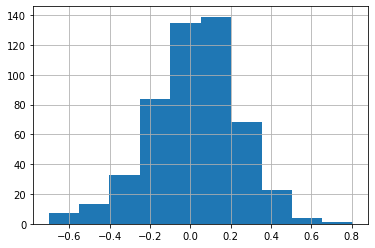

In [713]:
resid_log.hist();

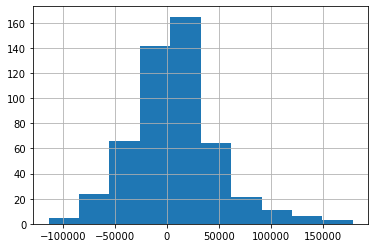

In [714]:
resid.hist();

The residuals have a relatively normal distribution, with a slight skew right

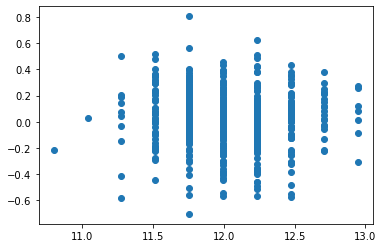

In [715]:
plt.scatter(pred_log, resid_log);

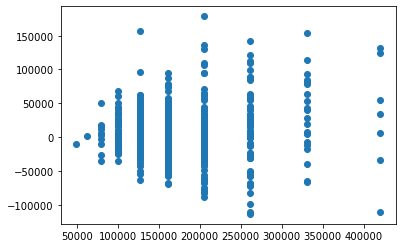

In [716]:
plt.scatter(pred, resid);

The residuals relative to predictions look relatively homoskedastic

In [717]:
res_std = resid.std()
res_std

41278.154701567444

The single variable model has a standard deviation error of about 41,000 dollars, leading to a range of about +/- 80,000 dollars at 95% confidence

In [718]:
res_mean = resid.mean()
res_mean

6996.98212383747

The single variable model is underpredicting reality by about 7,000 dollars, on average.

### Add more features

#### Looking to choose uncorrelated variables

In [719]:
df.head()

,Overall Qual,Gr Liv Area,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Year Built,Year Remod/Add,Full Bath,Garage Yr Blt,Mas Vnr Area,TotRms AbvGrd,Id,SalePrice
0,6,1479,475.0,2.0,725.0,725,1976,2005,2,1976.0,289.0,6,109,130500
1,7,2122,559.0,2.0,913.0,913,1996,1997,2,1997.0,132.0,8,544,220000
2,5,1057,246.0,1.0,1057.0,1057,1953,2007,1,1953.0,0.0,5,153,109000
3,5,1444,400.0,2.0,384.0,744,2006,2007,2,2007.0,0.0,7,318,174000
4,6,1445,484.0,2.0,676.0,831,1900,1993,2,1957.0,0.0,6,255,138500


In [720]:
ss = StandardScaler()
ss_features = df.drop(columns=['Id','SalePrice']).columns
Z_features = ss.fit_transform(df[ss_features])
df_Z = pd.DataFrame(Z_features, columns=df.drop(columns=['Id','SalePrice']).columns)
df_Z.head()

,Overall Qual,Gr Liv Area,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Year Built,Year Remod/Add,Full Bath,Garage Yr Blt,Mas Vnr Area,TotRms AbvGrd
0,-0.070648,-0.037374,0.009097,0.295903,-0.737417,-1.108572,0.152349,0.999334,0.780877,-0.013498,1.081310,-0.279431
1,0.631329,1.245246,0.397799,0.295903,-0.319080,-0.633555,0.816104,0.618877,0.780877,0.776808,0.184056,1.000585
2,-0.772625,-0.879155,-1.050579,-1.010840,0.001349,-0.269712,-0.610969,1.094448,-1.044772,-0.879070,-0.570324,-0.919439
3,-0.772625,-0.107190,-0.337958,0.295903,-1.496210,-1.060565,1.147981,1.094448,0.780877,1.153144,-0.570324,0.360577
4,-0.070648,-0.105195,0.050744,0.295903,-0.846452,-0.840743,-2.369919,0.428648,0.780877,-0.728536,-0.570324,-0.279431


In [721]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(df_Z.values, i) 
              for i in range(df_Z.shape[1])]
vif['variable'] = df_Z.columns
vif

,VIF,variable
0,2.711936,Overall Qual
1,4.900761,Gr Liv Area
2,5.920115,Garage Area
3,5.707451,Garage Cars
4,3.345144,Total Bsmt SF
5,3.483803,1st Flr SF
6,4.494177,Year Built
7,2.036009,Year Remod/Add
8,2.118975,Full Bath
9,4.945461,Garage Yr Blt


Makes sense that 'Garage Yr Blt' and 'Year Remod/Add' wouldn't add much information beyond 'Year Built'

In [722]:
df_Z_trimmed = df_Z.drop(columns=['Garage Yr Blt', 'Year Remod/Add'])
df_Z_trimmed.head()

,Overall Qual,Gr Liv Area,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Year Built,Full Bath,Mas Vnr Area,TotRms AbvGrd
0,-0.070648,-0.037374,0.009097,0.295903,-0.737417,-1.108572,0.152349,0.780877,1.081310,-0.279431
1,0.631329,1.245246,0.397799,0.295903,-0.319080,-0.633555,0.816104,0.780877,0.184056,1.000585
2,-0.772625,-0.879155,-1.050579,-1.010840,0.001349,-0.269712,-0.610969,-1.044772,-0.570324,-0.919439
3,-0.772625,-0.107190,-0.337958,0.295903,-1.496210,-1.060565,1.147981,0.780877,-0.570324,0.360577
4,-0.070648,-0.105195,0.050744,0.295903,-0.846452,-0.840743,-2.369919,0.780877,-0.570324,-0.279431


In [723]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(df_Z_trimmed.values, i) 
              for i in range(df_Z_trimmed.shape[1])]
vif['variable'] = df_Z_trimmed.columns
vif

,VIF,variable
0,2.523155,Overall Qual
1,4.891459,Gr Liv Area
2,5.520201,Garage Area
3,5.706659,Garage Cars
4,3.344874,Total Bsmt SF
5,3.447012,1st Flr SF
6,2.065328,Year Built
7,2.067303,Full Bath
8,1.372428,Mas Vnr Area
9,3.131051,TotRms AbvGrd


Let's remove the redundant column 'Garage Area'

In [724]:
df_Z_trimmed = df_Z.drop(columns=['Garage Area'])
df_Z_trimmed.head()

,Overall Qual,Gr Liv Area,Garage Cars,Total Bsmt SF,1st Flr SF,Year Built,Year Remod/Add,Full Bath,Garage Yr Blt,Mas Vnr Area,TotRms AbvGrd
0,-0.070648,-0.037374,0.295903,-0.737417,-1.108572,0.152349,0.999334,0.780877,-0.013498,1.081310,-0.279431
1,0.631329,1.245246,0.295903,-0.319080,-0.633555,0.816104,0.618877,0.780877,0.776808,0.184056,1.000585
2,-0.772625,-0.879155,-1.010840,0.001349,-0.269712,-0.610969,1.094448,-1.044772,-0.879070,-0.570324,-0.919439
3,-0.772625,-0.107190,0.295903,-1.496210,-1.060565,1.147981,1.094448,0.780877,1.153144,-0.570324,0.360577
4,-0.070648,-0.105195,0.295903,-0.846452,-0.840743,-2.369919,0.428648,0.780877,-0.728536,-0.570324,-0.279431


In [725]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(df_Z_trimmed.values, i) 
              for i in range(df_Z_trimmed.shape[1])]
vif['variable'] = df_Z_trimmed.columns
vif

,VIF,variable
0,2.711882,Overall Qual
1,4.824269,Gr Liv Area
2,2.086180,Garage Cars
3,3.329283,Total Bsmt SF
4,3.443307,1st Flr SF
5,4.335064,Year Built
6,2.032267,Year Remod/Add
7,2.080783,Full Bath
8,4.612632,Garage Yr Blt
9,1.383867,Mas Vnr Area


This looks like a reasonable place to start 

Let's see how each variable contributes to the cross val score

In [726]:
def find_next_feature(starting_features, dataframe):
    top_cv = 0
    top_column = ''
    for column in dataframe.drop(columns=starting_features).columns:
        iter_features = starting_features + [column]

        iter_X = df_Z_trimmed[iter_features]
        iter_y = y # using the same target as the main dataset

        iter_X_train, iter_X_test, iter_y_train, iter_y_test = train_test_split(iter_X, iter_y, random_state=42)

        iter_lr = LinearRegression()
        iter_cv = cross_val_score(iter_lr, iter_X_train, iter_y_train).mean()
#         print(f'Cross Val Score for {iter_features}: {iter_cv}')
        if iter_cv > top_cv:
            top_cv = iter_cv
            top_column = column
    print(f'The best feature to add is {top_column}, with a combined cv of {top_cv}')
    return [top_column]

In [727]:
next_feature = find_next_feature(['Overall Qual'], df_Z_trimmed)

The best feature to add is Gr Liv Area, with a combined cv of 0.7275545070098396


In [728]:
features = features + next_feature
features

['Overall Qual', 'Gr Liv Area']

And repeat...

In [729]:
next_feature = find_next_feature(features, df_Z_trimmed)

The best feature to add is Year Built, with a combined cv of 0.7692886396074624


In [730]:
features = features + next_feature
features

['Overall Qual', 'Gr Liv Area', 'Year Built']

In [731]:
next_feature = find_next_feature(features, df_Z_trimmed)

The best feature to add is Garage Cars, with a combined cv of 0.7794454431356306


In [732]:
features = features + next_feature
features

['Overall Qual', 'Gr Liv Area', 'Year Built', 'Garage Cars']

In [733]:
next_feature = find_next_feature(features, df_Z_trimmed)

The best feature to add is Year Remod/Add, with a combined cv of 0.7860146263598958


In [734]:
features = features + next_feature
features

['Overall Qual', 'Gr Liv Area', 'Year Built', 'Garage Cars', 'Year Remod/Add']

At this point we're seeing diminishing returns. Let's look at our residuals and see how these features interact with each other.

In [735]:
Z = df_Z_trimmed[features] # Scaled X values being given the label Z
# y = y: using the same target as the original dataset

Z_train, Z_test, y_train_log, y_test_log = train_test_split(Z, y, random_state=42)

lr_Z = LinearRegression()
lr_Z.fit(Z_train, y_train_log)
cross_val_score(lr_Z, Z_train, y_train_log).mean()

0.7860146263598958

In [736]:
pred_log_Z = lr_Z.predict(Z_test)
lr_Z.score(Z_train, y_train_log), lr_Z.score(Z_test, y_test)

(0.7893239073260196, -5.191634324199167)

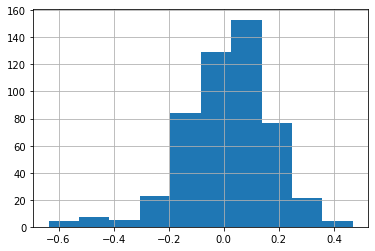

In [737]:
resid_log_Z = y_test_log - pred_log_Z
resid_log_Z.hist();

In [738]:
resid_log_Z.mean(), resid_log_Z.median()

(0.013682081366824039, 0.028171827689849493)

The residuals are slightly skew left, but have less variance than with the single feature predictions

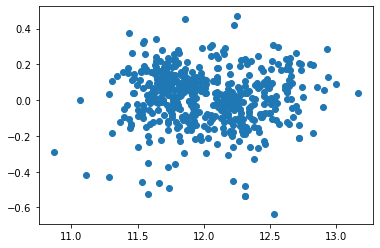

In [739]:
plt.scatter(pred_log_Z, resid_log_Z);

Homoskedaticity is still looking decent

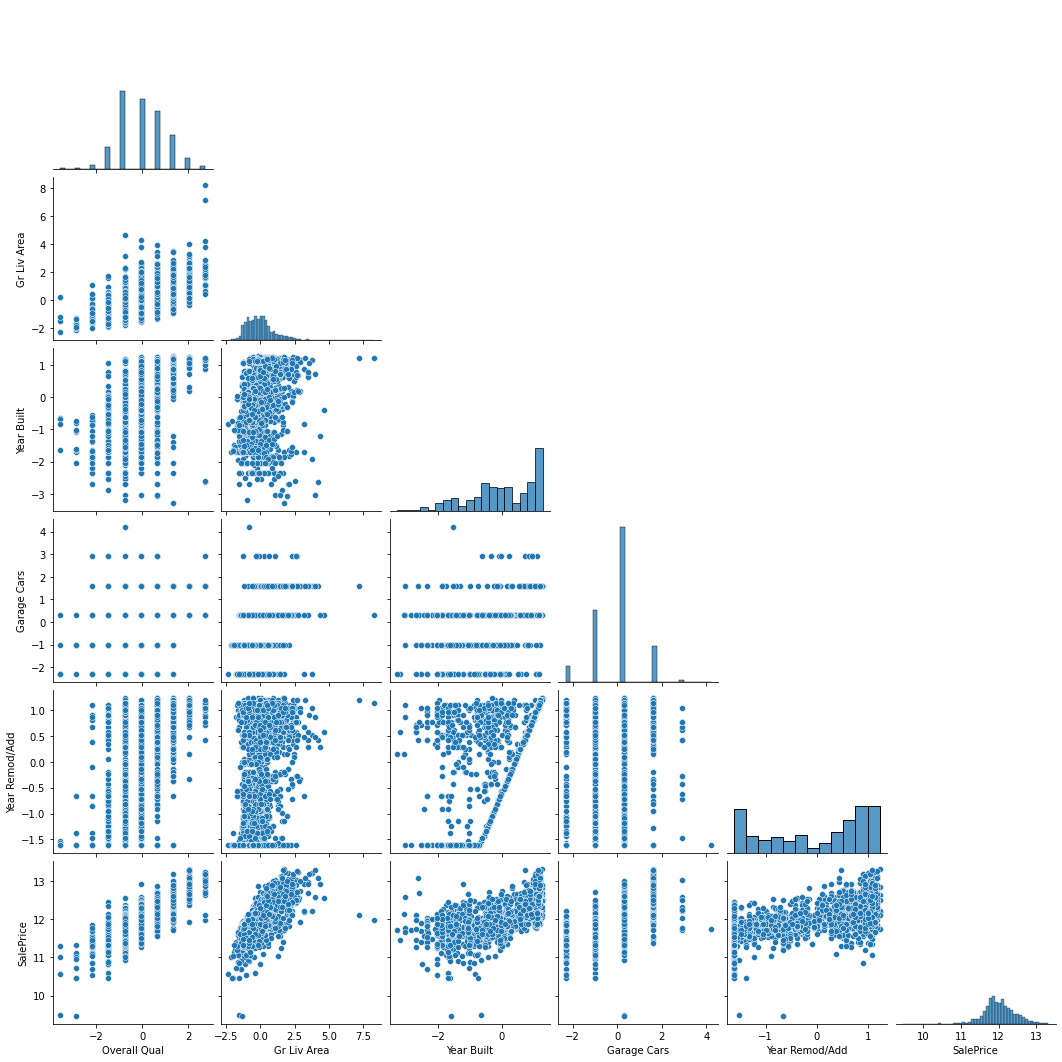

In [740]:
sns.pairplot(Z.join(y), corner=True);

A few things stick out: 1) 'Year Built' has a heavy left skew, maybe a reciprocal transform could help there; 2) 'Gr Liv Area' is heavily skewed right, and has a few notable outliers at the high end. A log transform may be useful(?), and the outliers are worthy of inspection; and 3) Generally, the features don't display strong linearity with one another, but do seem to show at least decent linearity with the target variable 'SalePrice'.

Let's look at the outliers and see what happens if we take them out

In [741]:
Z[Z['Gr Liv Area'] > 5]

,Overall Qual,Gr Liv Area,Year Built,Garage Cars,Year Remod/Add
948,2.737259,8.266740,1.214357,0.295903,1.142006
1862,2.737259,7.175615,1.214357,1.602645,1.189563


Interesting that they have practically identical values in multiple columns

In [742]:
df.iloc[[948, 1862],:]

,Overall Qual,Gr Liv Area,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Year Built,Year Remod/Add,Full Bath,Garage Yr Blt,Mas Vnr Area,TotRms AbvGrd,Id,SalePrice
948,10,5642,1418.0,2.0,6110.0,4692,2008,2008,2,2008.0,796.0,12,1499,160000
1862,10,5095,1154.0,3.0,5095.0,5095,2008,2009,2,2008.0,1224.0,15,2181,183850


Wow, both of those homes have a ridiculous number of rooms. Maybe rooms relative to living area would be a good feature...

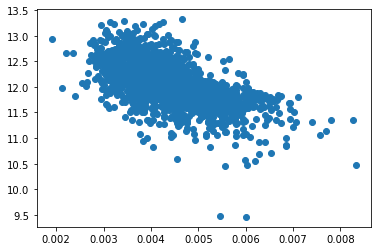

In [743]:
df['GR Rooms by GR Liv Area'] = df['TotRms AbvGrd']/df['Gr Liv Area']
plt.scatter(df['GR Rooms by GR Liv Area'], df['SalePrice'].map(np.log));

In [744]:
df[['GR Rooms by GR Liv Area']].join(y).corr()

,GR Rooms by GR Liv Area,SalePrice
GR Rooms by GR Liv Area,1.000000,-0.585451
SalePrice,-0.585451,1.000000


Well, it's something, but nothing earthshattering... Let's try some transformations

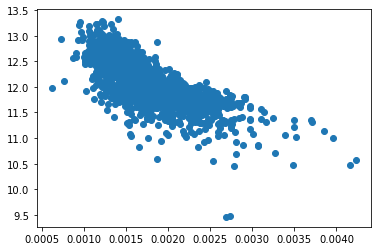

In [745]:
df['GR Rooms by GR Liv Area'] = df['TotRms AbvGrd'].map(lambda x: x ** .5)/df['Gr Liv Area']
plt.scatter(df['GR Rooms by GR Liv Area'], df['SalePrice'].map(np.log));

Well, it's something, but nothing earthshaking... Let's try some transforms

In [746]:
df[['GR Rooms by GR Liv Area']].join(y).corr()

,GR Rooms by GR Liv Area,SalePrice
GR Rooms by GR Liv Area,1.000000,-0.716722
SalePrice,-0.716722,1.000000


Well, that's a pretty strong correlation, but still has some outliers. Let's try plugging it in.

In [749]:
# Just taking a stab at removing the outliers
df.drop([948, 1862], inplace=True)
y.drop([948, 1862], inplace=True)

In [750]:
ss = StandardScaler()
ss_features = df.drop(columns=['Id','SalePrice']).columns
Z_features = ss.fit_transform(df[ss_features])
df_Z = pd.DataFrame(Z_features, columns=df.drop(columns=['Id','SalePrice']).columns)
df_Z.head()

,Overall Qual,Gr Liv Area,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Year Built,Year Remod/Add,Full Bath,Garage Yr Blt,Mas Vnr Area,TotRms AbvGrd,GR Rooms by GR Liv Area
0,-0.068164,-0.030654,0.012899,0.296889,-0.767389,-1.150490,0.153585,1.000664,0.781498,-0.012324,1.101555,-0.277776,-0.354244
1,0.636077,1.291034,0.404227,0.296889,-0.326069,-0.653337,0.817495,0.620139,0.781498,0.778145,0.191824,1.015319,-1.096119
2,-0.772405,-0.898076,-1.053933,-1.010066,0.011963,-0.272540,-0.609913,1.095795,-1.043800,-0.878076,-0.573045,-0.924324,0.699811
3,-0.772405,-0.102596,-0.336500,0.296889,-1.567868,-1.100246,1.149451,1.095795,0.781498,1.154559,-0.573045,0.368772,0.049790
4,-0.068164,-0.100541,0.054827,0.296889,-0.882414,-0.870181,-2.369276,0.429876,0.781498,-0.727511,-0.573045,-0.277776,-0.264814


In [751]:
features = features + ['GR Rooms by GR Liv Area']
features

['Overall Qual',
 'Gr Liv Area',
 'Year Built',
 'Garage Cars',
 'Year Remod/Add',
 'GR Rooms by GR Liv Area']

In [752]:
Z = df_Z[features] # Scaled X values being given the label Z
# y = y: using the same target as the original dataset
Z

,Overall Qual,Gr Liv Area,Year Built,Garage Cars,Year Remod/Add,GR Rooms by GR Liv Area
0,-0.068164,-0.030654,0.153585,0.296889,1.000664,-0.354244
1,0.636077,1.291034,0.817495,0.296889,0.620139,-1.096119
2,-0.772405,-0.898076,-0.609913,-1.010066,1.095795,0.699811
3,-0.772405,-0.102596,1.149451,0.296889,1.095795,0.049790
4,-0.068164,-0.100541,-2.369276,0.296889,0.429876,-0.264814
...,...,...,...,...,...,...
2020,1.340318,0.481166,1.182646,0.296889,1.095795,-0.641273
2021,-1.476645,-1.300954,-1.041455,0.296889,-1.615447,1.175759
2022,-0.068164,0.861434,-1.439801,0.296889,-1.615447,-0.556107
2023,-1.476645,-0.604139,-0.510326,-1.010066,-1.330053,0.529430


In [753]:
Z_train, Z_test, y_train_log, y_test_log = train_test_split(Z, y, random_state=42)

lr_Z = LinearRegression()
lr_Z.fit(Z_train, y_train_log)
cross_val_score(lr_Z, Z_train, y_train_log).mean()

0.8138676410744452

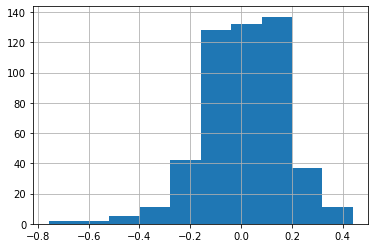

In [754]:
pred_log_Z = lr_Z.predict(Z_test)
resid_log_Z = y_test_log - pred_log_Z
resid_log_Z.hist();

In [755]:
resid_log_Z.mean()

0.009705860316965567

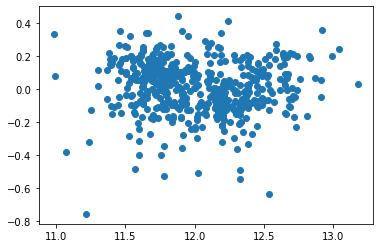

In [756]:
plt.scatter(pred_log_Z, resid_log_Z);

Not all that different...

In [757]:
lr_Z.score(Z_train, y_train_log), lr_Z.score(Z_test, y_test_log)

(0.815050587937594, 0.8402102839434711)

In [767]:
lr_Z.coef_

array([ 0.15927821,  0.11320605,  0.07080005,  0.04933953,  0.03975473,
       -0.03889363])

Let's see how this scores on Kaggle.
- With outliers included: 33498
- With outliers excluded: 30416

### Process Submission Data

In [758]:
df_kaggle = pd.read_csv('../datasets/filtered_test_dataset.csv')
df_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Columns: 148 entries, Id to Yr Sold_2010
dtypes: float64(2), int64(146)
memory usage: 1015.3 KB


Add engineered features

In [759]:
df_kaggle['GR Rooms by GR Liv Area'] = df_kaggle['TotRms AbvGrd'].map(lambda x: x ** .5)/df_kaggle['Gr Liv Area']
df_kaggle.head()

,Id,Overall Qual,Gr Liv Area,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Year Built,Year Remod/Add,Full Bath,...,Mo Sold_5,Mo Sold_6,Mo Sold_7,Mo Sold_8,Mo Sold_9,Yr Sold_2007,Yr Sold_2008,Yr Sold_2009,Yr Sold_2010,GR Rooms by GR Liv Area
0,2658,6,1928,440,1,1020,908,1910,1950,2,...,0,0,0,0,0,0,0,0,0,0.001556
1,2718,5,1967,580,2,1967,1967,1977,1977,2,...,0,0,0,1,0,0,0,0,0,0.001608
2,2414,7,1496,426,2,654,664,2006,2006,2,...,0,0,0,0,1,0,0,0,0,0.001769
3,1989,5,968,480,2,968,968,1923,2006,1,...,0,0,1,0,0,1,0,0,0,0.002310
4,625,6,1394,514,2,1394,1394,1963,1963,1,...,0,0,1,0,0,0,0,1,0,0.001757


In [760]:
kaggle_features = ss.transform(df_kaggle[ss_features])
df_kaggle_sc = pd.DataFrame(kaggle_features, columns=ss_features)
df_kaggle_sc.head()

,Overall Qual,Gr Liv Area,Garage Area,Garage Cars,Total Bsmt SF,1st Flr SF,Year Built,Year Remod/Add,Full Bath,Garage Yr Blt,Mas Vnr Area,TotRms AbvGrd,GR Rooms by GR Liv Area
0,-0.068164,0.892267,-0.150154,-1.010066,-0.074892,-0.666560,-2.037321,-1.615447,0.781498,-2.496656,-0.573045,1.661867,-0.584106
1,-0.772405,0.972431,0.502058,0.296889,2.148140,2.133892,0.186780,-0.331174,0.781498,0.025317,-0.573045,2.308414,-0.465578
2,0.636077,0.004290,-0.215375,0.296889,-0.934058,-1.311801,1.149451,1.048229,0.781498,1.116918,-0.573045,0.368772,-0.096366
3,-0.772405,-1.081015,0.036193,0.296889,-0.196959,-0.507894,-1.605779,1.048229,-1.043800,-1.555621,-0.573045,-0.924324,1.146171
4,-0.068164,-0.205372,0.194587,0.296889,0.803053,0.618633,-0.277957,-0.997093,-1.043800,-0.501662,0.858187,-0.277776,-0.122491


In [761]:
X_kaggle_sc = df_kaggle_sc[features].copy()

In [762]:
X_kaggle_sc.head()

,Overall Qual,Gr Liv Area,Year Built,Garage Cars,Year Remod/Add,GR Rooms by GR Liv Area
0,-0.068164,0.892267,-2.037321,-1.010066,-1.615447,-0.584106
1,-0.772405,0.972431,0.186780,0.296889,-0.331174,-0.465578
2,0.636077,0.004290,1.149451,0.296889,1.048229,-0.096366
3,-0.772405,-1.081015,-1.605779,0.296889,1.048229,1.146171
4,-0.068164,-0.205372,-0.277957,0.296889,-0.997093,-0.122491


In [763]:
pred_kaggle = lr_Z.predict(X_kaggle_sc)

In [764]:
df_kaggle['SalePrice'] = pred_kaggle
df_kaggle['SalePrice'] = df_kaggle['SalePrice'].map(np.exp)
df_kaggle['SalePrice'].head()

0    143439.402124
1    169222.509317
2    211577.298782
3    117212.634106
4    154058.057602
Name: SalePrice, dtype: float64

In [765]:
submission = df_kaggle[['Id', 'SalePrice']]
submission.set_index('Id', inplace=True)
submission

,SalePrice
Id,
2658,143439.402124
2718,169222.509317
2414,211577.298782
1989,117212.634106
625,154058.057602
...,...
1662,184696.442489
1234,194965.259926
1373,125377.243493


In [766]:
# submission.to_csv('../outputs/mlr_17_submission.csv')